# Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt


from IPython.display       import Image
from IPython.core.display  import HTML

## Helper Functions

In [2]:
def jupyter_settings():
   %matplotlib inline
   %pylab inline
   
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [25, 12]
   plt.rcParams['font.size'] = 24
   
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# Data Description

In [4]:
df1 = df_raw.copy()

## Rename Columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## Data Dimensions

In [7]:
print ('Number of Rows: {}'.format( df1.shape[0]))
print ('Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime( df1['date'])

## Missing Values

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout Missing Values (NA)

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance - I will assume that the reason for being blank is because either there is no competitors or they are too far to be considered competitors
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 1000000.0 if math.isnan(x) else x)

#competition_open_since_month - I will assume that the reason for being blank is because either there is no competitors or the store was opened long before ours or someone did not add this data   
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
               
#promo_interval  
    # Map to convert number into name
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }
    # Fill with 0 so it does not compare with 'NaN'
df1['promo_interval'].fillna(0, inplace=True)
    # Extract the month of date and apply the month map to translate it
df1['month_map'] = df1['date'].dt.month.map(month_map)
    # Check if the month_map matches with the promo interval to understand if the promotion is happening (1) or not (0)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## Descriptive Statistics

In [15]:
# Split numerical and categorical features
num_attributes = df1.select_dtypes( include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

###  Numerical Attributes

In [16]:
#Central Tendency - mean, meadian

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat

m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,1000000.0,999980.0,8013.285087,2330.0,51204.209542,18.891734,362.875468
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


###  Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

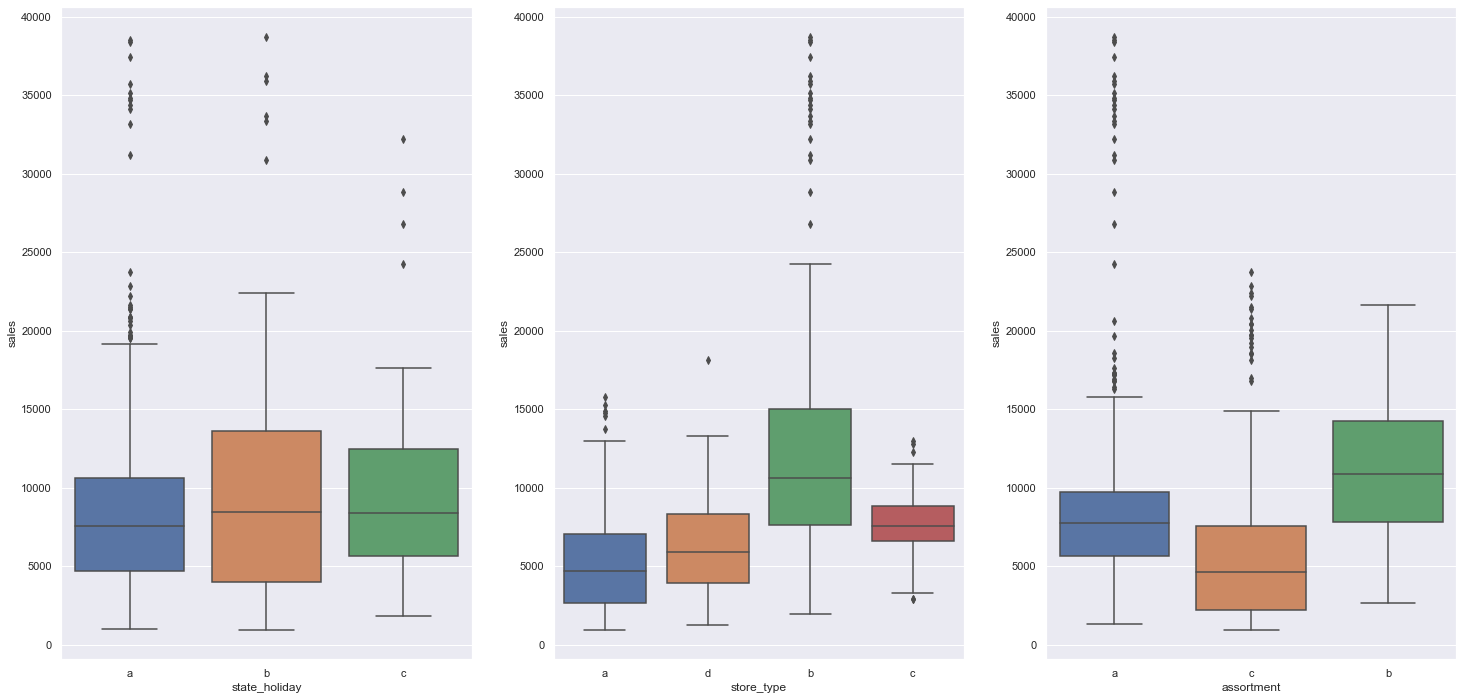

In [18]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] > 0)]

plt.subplot (1 , 3, 1)
sns.boxplot(x='state_holiday' , y= 'sales', data= aux1)

plt.subplot (1 , 3, 2)
sns.boxplot(x='store_type' , y= 'sales', data= aux1)

plt.subplot (1 , 3, 3)
sns.boxplot(x='assortment' , y= 'sales', data= aux1)

# Feature Engineering

In [22]:
df3 = df1.copy()

## MindMap

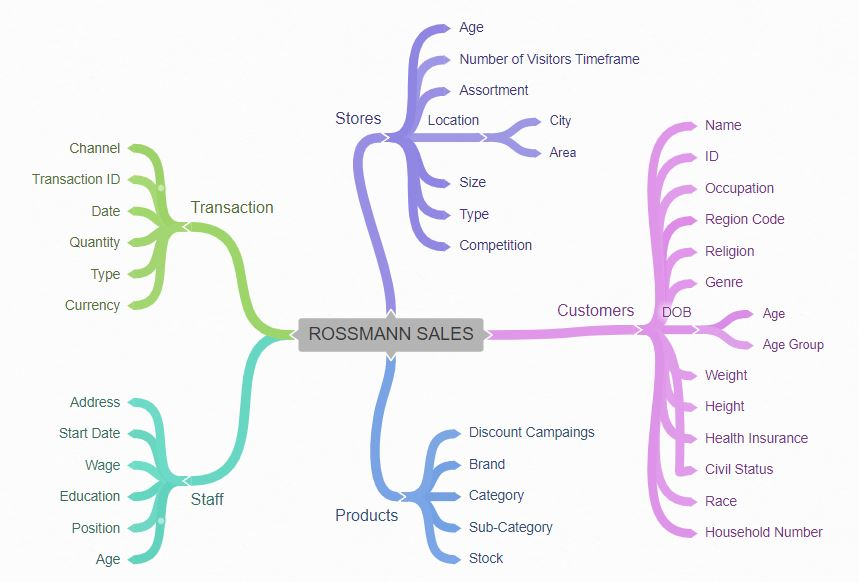

In [21]:
Image( 'img/mindmap.jpg')

## Hypothesis Formulation

### Stores Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with higher stock volumes should sell more.

**3.** Bigger stores should sell more.

**4.** Smaller stores should sell less.

**5.** Stores with bigger assortments should sell more.

### Product Hypothesis

**1.** Products which are part of more discounts campaigns should sell more.

**2.** Products which have more front rows exposure should sell more.

**3.** Cheaper products should sell more.

**4.** Products which have lower prices for longer should sell more.

### Time Hypothesis

**1.** Stores that close on bank holidays should sell less.

**2.** Stores that are open on weekends should sell more.

## Final List of Hypothesis

## Feature Creation

In [30]:
# year
df3['year']= df3['date'].dt.year

#month
df3['month']= df3['date'].dt.month

#day
df3['day']= df3['date'].dt.day

#week of year
df3['week_of_year']= df3['date'].dt.weekofyear

#year week
df3['year_week']= df3['date'].dt.strftime( '%Y-%W' )

<ipython-input-30-6721ff5e86a5>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df3['week_of_year']= df3['date'].dt.weekofyear


In [48]:
# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df3['competition_time_month'] = (( df3['date'] - df3['competition_since']  ) /30 ).apply( lambda x: x.days).astype(int)

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime ( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
df3['promo_time_week'] = ( (df3['date'] - df3['promo_since'] ) / 7).apply( lambda x: x.days ).astype (int)

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

# state holidays
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [49]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# Data Filtering

In [51]:
df4 = df3.copy()

In [53]:
df4.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Rows Filtering

In [54]:
df4 = df4[(df4['open'] != 0 ) & (df4['sales'] > 0)]  

## Columns Selection

In [55]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4 = df4.drop(cols_drop, axis = 1)

# Exploratory Data Analysis (EDA)

In [58]:
df5 = df4.copy()

## Univariate Analysis

### Response Variable

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

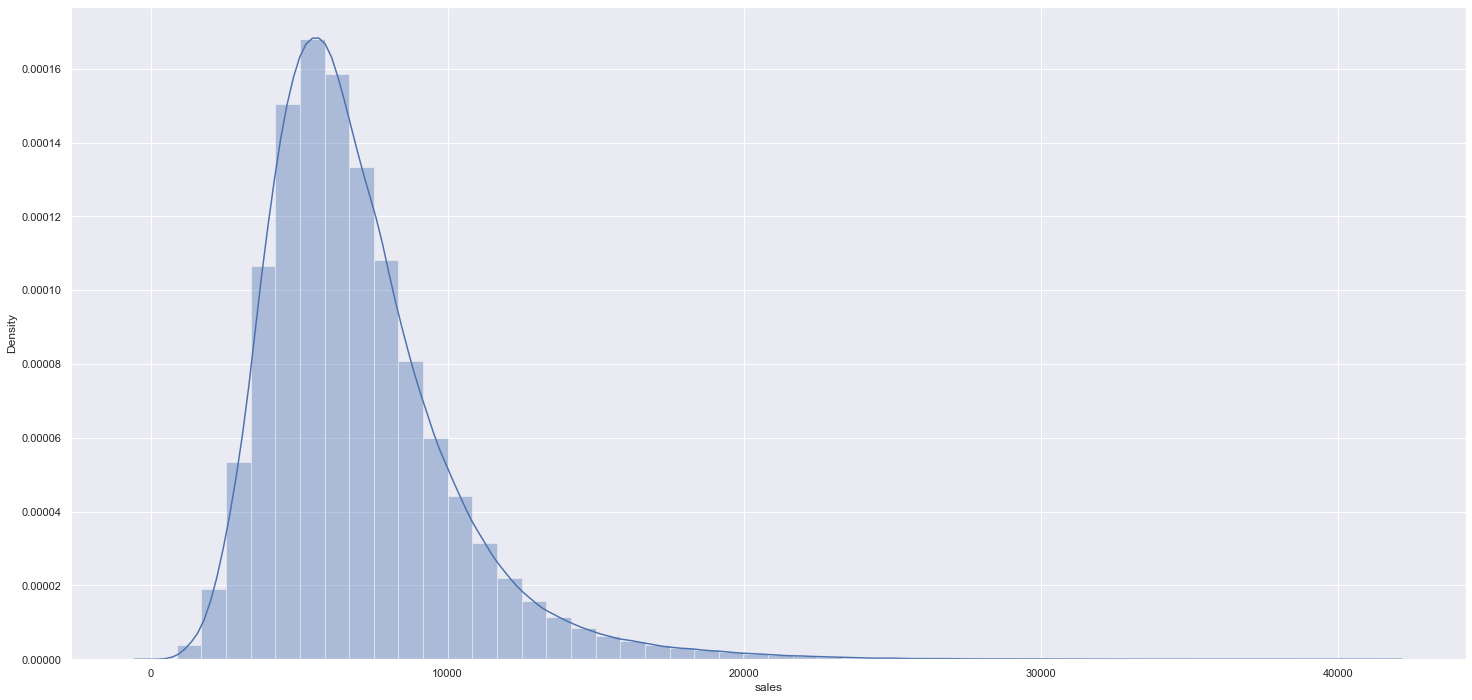

In [60]:
sns.distplot(df5['sales'])

### Numerical Variable

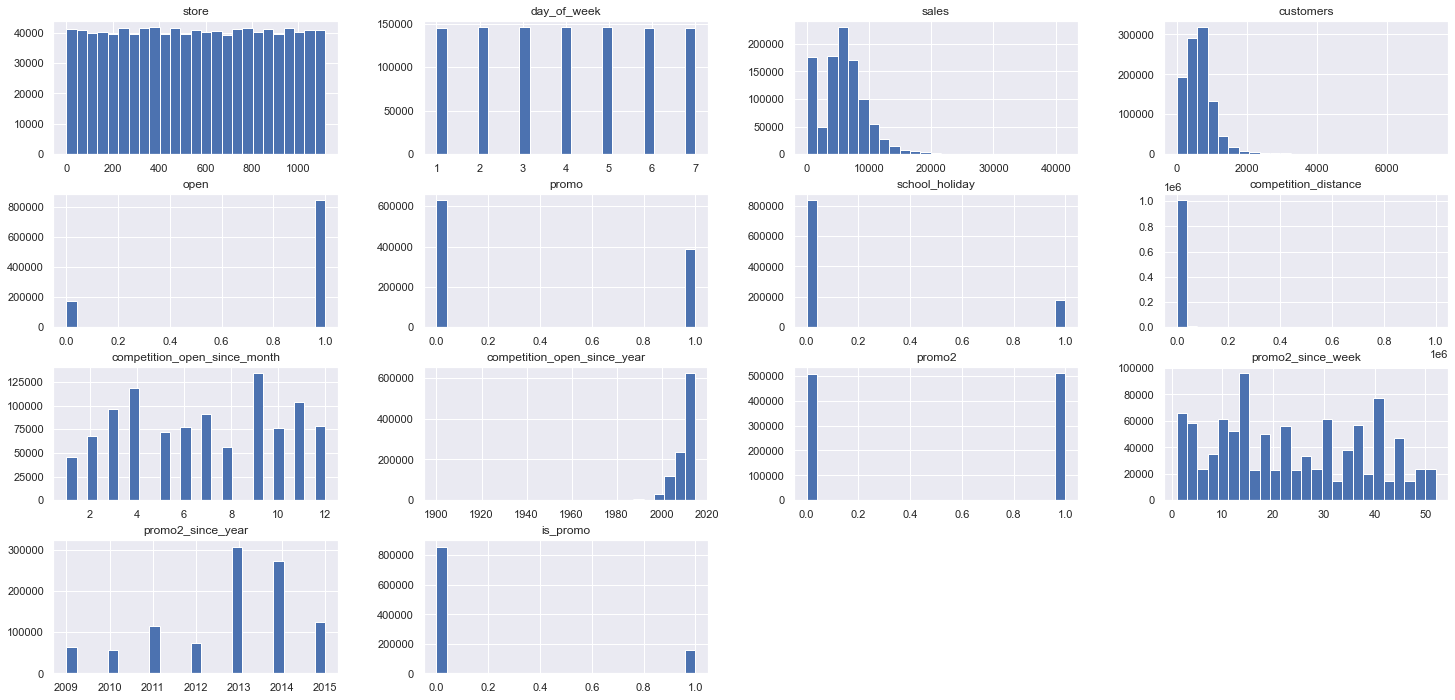

In [63]:
num_attributes.hist(bins=25);

### Categorical Variable

In [67]:
df5['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

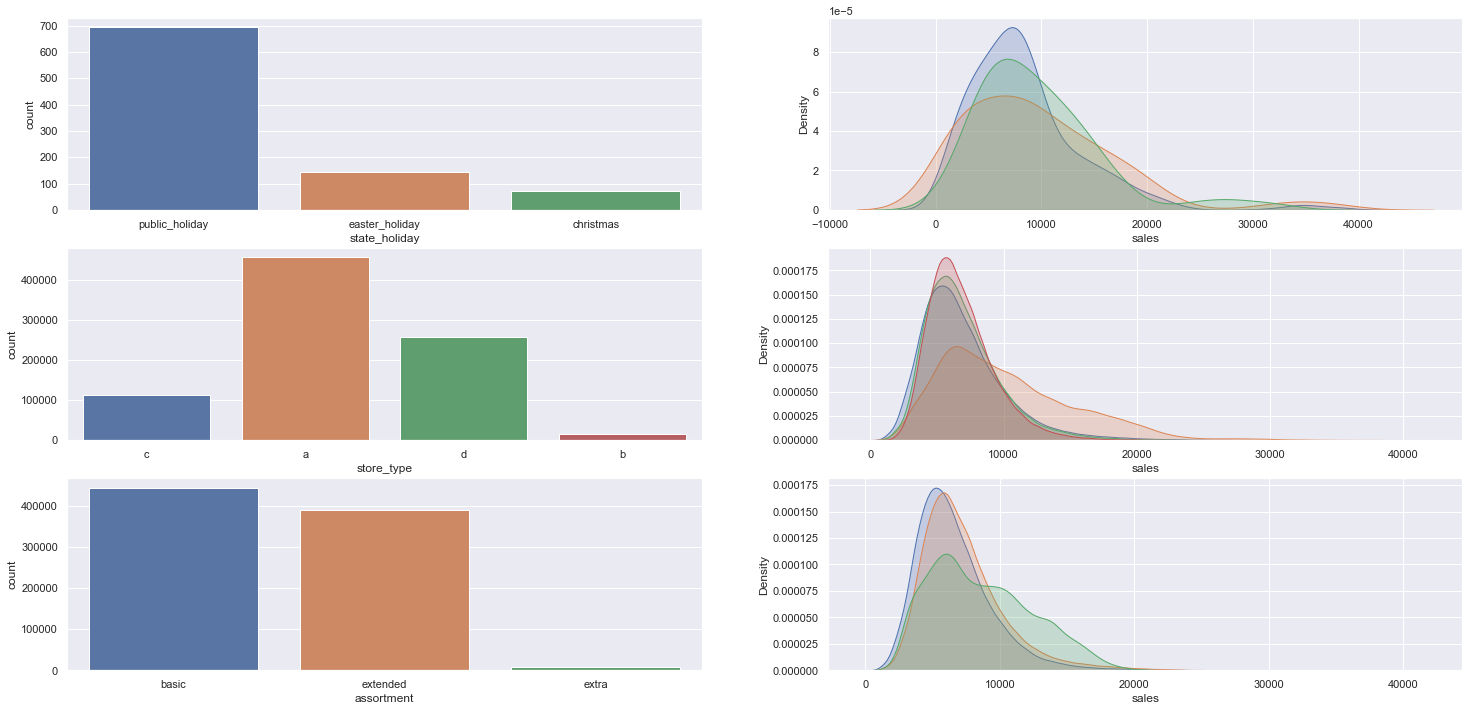

In [80]:
# state_holiday
plt.subplot(3,2,1)
a = df5[df5['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df5['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df5['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True)

## Bivariate Analysis

### Response Variable

### Numerical Variable

## Multivariable Analysis


### Response Variable

### Numerical Variable